<a href="https://colab.research.google.com/github/kattens/AutoEncoders-for-Protein-Sequences/blob/main/Blast_Run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Recap:

We have prepared a CSV file from an initial file named `cdot_targets`, containing PubChem IDs. For each PubChem ID, we searched PubChem to find interacting targets and documented these interactions in the "Target Names" column. Additionally, we included "Accession IDs," corresponding to UniProt IDs for each target, and a column for gene names to improve the accuracy of BLAST searches.

## Goal:

Our objective is to run BLAST searches using UniProt IDs from our CSV file against targets related to Plasmodium malaria.

## Tools and Libraries:

- **NCBIWWW**: Facilitates online BLAST searches.
- **NCBIXML**: Parses the XML results from BLAST into a manageable Python format.
- **SeqIO**: Utilized for reading and writing sequences across various bioinformatics file formats.

## Implementation:

Since the base code is operational, our next step is to save the data in a JSON file for each accession ID. This will allow us to manage and analyze the results efficiently.

## List of Plasmodium Variants on UniProt:

####our focus:
- **Plasmodium falciparum** - Taxon ID: 5833



#### other variants:

- **Plasmodium malariae** - Taxon ID: 5858
- **Plasmodium vivax** - Taxon ID: 5855
- **Plasmodium ovale** - Taxon ID: 36330
- **Plasmodium berghei** - Taxon ID: 5821
- **Plasmodium reichenowi** - Taxon ID: 5854
- **Plasmodium gonderi** - Taxon ID: 77519
- **Plasmodium chabaudi** - Taxon ID: 5825

## Next Steps:

- Iterate through all UniProt IDs in the CSV file, perform a BLAST search for each, and store the results in a JSON file for subsequent analysis.


In [ ]:
#install Bio
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 26.7 MB/s eta 0:00:00


In [ ]:
import csv
import pandas as pd
from Bio.Blast import NCBIWWW,NCBIXML
from Bio import Entrez, SeqIO
import requests

In [ ]:
path = '/content/drive/MyDrive/target_results.csv'
df = pd.read_csv(path)

In [ ]:
df.head()

,PubChem ID,Target Names,Accession IDs,Target Gene Name
0,5330175,"['Tyrosineprotein', 'NTMT1', 'FH', 'Chain', 'N...","[A0A0K2VLS4, S4R3J7, P07954, P0C023, O96028, Q...","['NTMT1', 'FH', 'NSD2', 'KDR', 'GPX4', 'COMT',..."
1,5311340,"['ID4', 'ALDH1A1', 'EZH2', 'MYC', 'GLA', 'APOB...","[P47928, Q5SYQ8, Q921E6, A0A8A5GQJ2, O53996, P...","['ID4', 'ALDH1A1', 'EZH2', 'MYC', 'GLA', 'APOB..."
2,11511120,"['AcylCoA', 'Epidermal', 'Mitogenactivated', '...","[B2BXS0, Q9Z0P7, L8GZV5, P05067, Q9ZNZ7, A0A0B...","['NADH', 'MAP', 'CYP2C9', 'NSD2', 'ERBB4', 'GP..."
3,221354,"['CYP2D6', 'lethal', 'ALDH1A1', 'RGS12', 'ALOX...","[P10635, A1Z198, Q5SYQ8, E9Q652, I3L1D5, P0C02...","['CYP2D6', 'ALDH1A1', 'RGS12', 'ALOX15B', 'HPG..."
4,6806409,[],[],[]


In [ ]:
def clean_and_convert_to_list(id_item):
    # Check if the item is a string and needs conversion
    if isinstance(id_item, str) and id_item.startswith("[") and id_item.endswith("]"):
        id_item = id_item[1:-1]  # Remove the square brackets
        id_list = id_item.split(", ")  # Split the string into a list
        id_list = [id.strip("'") for id in id_list]  # Remove quotes from each element
        return id_list
    # Return the item as is if it's already a list or not a string
    return id_item

# Apply the conversion function to each element in the column
df['Accession IDs'] = df['Accession IDs'].apply(clean_and_convert_to_list)

# Verify the conversion
print(df['Accession IDs'].head())


0    [A0A0K2VLS4, S4R3J7, P07954, P0C023, O96028, Q...
1    [P47928, Q5SYQ8, Q921E6, A0A8A5GQJ2, O53996, P...
2    [B2BXS0, Q9Z0P7, L8GZV5, P05067, Q9ZNZ7, A0A0B...
3    [P10635, A1Z198, Q5SYQ8, E9Q652, I3L1D5, P0C02...
4                                                   []
Name: Accession IDs, dtype: object


In [ ]:
print(type(df['Accession IDs'].iloc[0]))
print(df['Accession IDs'].iloc[0])

<class 'list'>
['A0A0K2VLS4', 'S4R3J7', 'P07954', 'P0C023', 'O96028', 'Q3UQZ6', 'K7EJ20', 'A0A173GP47', 'A0A286SD53', 'Q95M86', 'A0A0K2VLS4', 'O55239', 'Q9P1Y0', 'A0A0K2VLS4', 'A0A0K2VLS4', 'H3BU54', 'A0A0H4TJD6', 'Q63694', 'A0A0K2VLS4', 'P14647', 'E7EVM8', 'D3YY46', 'Q90738', 'S5RV20', 'P10484', 'A0A0D9RI81', 'P01574', 'P11086', 'P05484', 'A0A0K2VLS4', 'P11352', 'L8GNA7', 'Q9Y294', 'Q6PD10', 'Q14749', 'P10635', 'H6A2B4', 'P24462']


### **BLAST Parameters and Possible Values**

#### **`blast_db` (Database to search against)**
- `"nr"` – Non-redundant protein database (largest)
- `"pdb"` – Protein Data Bank (structures)
- `"swissprot"` – Curated protein sequences
- `"refseq_protein"` – Reference protein sequences
- `"pat"` – Patent sequences
- `"tsa"` – Transcriptome Shotgun Assembly
- `"env_nr"`, `"env_nt"` – Environmental samples (proteins or nucleotides)

#### **`blast_type` (Type of BLAST search)**
- `"blastp"` – Protein vs. protein
- `"blastn"` – Nucleotide vs. nucleotide
- `"blastx"` – Translated nucleotide vs. protein
- `"tblastn"` – Protein vs. translated nucleotide
- `"tblastx"` – Translated nucleotide vs. translated nucleotide

#### **`expect` (E-value threshold, lower values filter weak hits)**
- `1e-3` – Very strict
- `0.1` – Common default
- `1` – Moderate filtering
- `10` – Relaxed filtering
- `100` – Very loose filtering

#### **`matrix_name` (Scoring matrix for protein alignments)**
- `"BLOSUM62"` – Default, general use
- `"BLOSUM45"` – Better for divergent sequences
- `"BLOSUM80"` – Better for closely related sequences
- `"PAM30"` – Sensitive to short alignments
- `"PAM70"` – Intermediate
- `"PAM250"` – Older, used for distant homology

#### **`alignments` (Number of alignments to show)**
- `10`, `50`, `100`, `200`, `500` – Higher values show more results

#### **`hitlist_size` (Number of hits to return)**
- `10`, `50`, `100`, `200`, `500` – Determines how many sequences to keep

#### **`filter` (Low-complexity filtering)**
- `"T"` – Enable filtering (default, removes repetitive regions)
- `"F"` – Disable filtering (keeps all sequences)

#### **`gapcosts` (Gap opening and extension penalties)**
- `"11 1"` – Default (moderate penalty)
- `"9 2"` – Alternative setting
- `"8 2"` – Allows more gaps
- `"5 2"` – Very permissive

#### **`entrez_query` (Limit search to a specific organism)**
- `"txid9606[ORGN]"` – Humans  
- `"txid10090[ORGN]"` – Mice  
- `"txid10116[ORGN]"` – Rats  
- Replace `txidXXXX` with any species’ taxonomy ID to filter results.


In [ ]:
import requests
from Bio.Blast import NCBIWWW, NCBIXML

def fetch_uniprot_sequence(accession_id):
    """
    Fetch a sequence from UniProt using the accession ID.
    """
    url = f"https://rest.uniprot.org/uniprotkb/{accession_id}.fasta"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            return response.text
        else:
            print(f"UniProt query failed for {accession_id} with status code: {response.status_code}")
            return None
    except Exception as e:
        print(f"Error querying UniProt for {accession_id}: {e}")
        return None

def fetch_and_blast_sequence(accession_id, taxonomy, blast_db="pdb",
                             blast_type="blastp", expect=1, matrix_name="BLOSUM62",
                             alignments=500, hitlist_size=500, filter="F", gapcosts="11 1"):
    """
    Fetch a sequence from UniProt, run BLAST, print and return results as a dictionary.
    """
    sequence_data = fetch_uniprot_sequence(accession_id)
    if not sequence_data:
        print(f"No sequence data found for Accession ID: {accession_id}")
        return None

    entrez_query = f"txid{taxonomy}[ORGN]"
    result_handle = NCBIWWW.qblast(blast_type, blast_db, sequence_data,
                                   expect=expect, matrix_name=matrix_name,
                                   alignments=alignments, hitlist_size=hitlist_size,
                                   filter=filter, gapcosts=gapcosts,
                                   entrez_query=entrez_query)

    blast_record = NCBIXML.read(result_handle)
    blast_results = []
    print(f"Results for Accession ID: {accession_id}")
    for alignment in blast_record.alignments:
        for hsp in alignment.hsps:
            result_detail = {
                "hit_id": alignment.hit_id,
                "hit_def": alignment.hit_def,
                "e_value": hsp.expect,
                "score": hsp.score,
                "query_align": hsp.query[:100],  # First 100 characters for example
                "subject_align": hsp.sbjct[:100]
            }
            blast_results.append(result_detail)

            # Print each result
            print(f"  Hit ID: {alignment.hit_id}")
            print(f"  Hit Description: {alignment.hit_def}")
            print(f"    E-value: {hsp.expect}")
            print(f"    Score: {hsp.score}")
            print(f"    Query Alignment: {hsp.query[:500]}...")
            print(f"    Subject Alignment: {hsp.sbjct[:500]}...")
            print("-" * 80)

    if blast_results:
        return blast_results
    else:
        print(f"No BLAST results found for Accession ID: {accession_id}")
        return None


#Explanation for the results:
**Hit ID**: This is a unique identifier for the sequence in the database that matched your query. In your example, emb|SBS97131.1| identifies the sequence in the database.

**Hit Description**: This provides more detailed information about the hit, including the name of the protein and the species. For instance, cdc2-related protein kinase 3, putative (CRK3) [Plasmodium malariae] tells you what the protein is and from which species it comes.

**E-value (Expectation value)**: This is a very important metric that describes the number of hits one can "expect" to see by chance when searching a database of a particular size. It’s a measure of the randomness of the match, where a lower E-value indicates a more significant match. An E-value of 0.00065012 suggests that the hit is quite significant.

**Score**: This is the computed score of the alignment, which takes into account the scoring matrix used in the analysis (like BLOSUM62, PAM250, etc.). Higher scores generally indicate better alignments.

**Query Alignment and Subject Alignment**: These are the actual sequences from your query and the database that align with each other. These give you a visual insight into how similar the query sequence is to the database sequence.

In [ ]:
# Example usage
fetch_and_blast_sequence("P10635", 5833)

Results for Accession ID: P10635
No BLAST results found for Accession ID: P10635


In [ ]:
# Example usage
fetch_and_blast_sequence("L8GZV5", 5833)

Results for Accession ID: L8GZV5
  Hit ID: pdb|3NIE|A
  Hit Description: Chain A, MAP2 kinase [Plasmodium falciparum] >pdb|3NIE|B Chain B, MAP2 kinase [Plasmodium falciparum]
    E-value: 1.15825e-41
    Score: 374.0
    Query Alignment: LEHHGGPATTAPLPRLTDLYDLQHVIGQGAYGVVWLALDRRSGQRVAVKKIADVFGDSKEAKRTLREVRLMRHFRGSSPHILAIHDLVPAMAEGKEEGEEEAVTMHNFRDLYVVTEFMDGGDLSQLTCGNKPPPEAAAHSGWHRPDEQLVKAVAFGLLSGLRVIHAARVLHRDLRPKNLLLSGDTVKTRTEQIADFGMGR--GKAKKLETAQN---------------RMKLSLMEFVSNRYYTAPEGLLPNNEYSYPV---------TEMLLGRNVFRD------SRYP-------------------------DQMRTVISVLGTPAEEDLASIASGRNEKFRAYIRTLQAHEPNRLWTLLPNLSAEGKDFLQRLLMFNPNKRATAQEALRHPWLRDVAAAHTSAPGSTADDGDDEPGDHGVVAPFEGGDIEAADDESALRPLLWREALSYRG...
    Subject Alignment: LYFQGAIIKNVKVP---DNYEIKHLIGRGSYGYVYLAYDKNANKNVAIKKVNRMFEDLIDCKRILREITILN--RLKSDYIIRLHDLI--IPED----------LLKFDELYIVLEIAD-SDLKKLF---KTPIFLT---------EQHVKTILYNLLLGEKFIHESGIIHRDLKPANCLLNQDC----SVKICDFGLARTINSDKDIHIVNDLEEKEENEEPGPHNKNLKKQLTSHVVTRWYRAPELILLQENYTNSIDIWSTGCIFAELL---NMMKS

[{'hit_id': 'pdb|3NIE|A',
  'hit_def': 'Chain A, MAP2 kinase [Plasmodium falciparum] >pdb|3NIE|B Chain B, MAP2 kinase [Plasmodium falciparum]',
  'e_value': 1.15825e-41,
  'score': 374.0,
  'query_align': 'LEHHGGPATTAPLPRLTDLYDLQHVIGQGAYGVVWLALDRRSGQRVAVKKIADVFGDSKEAKRTLREVRLMRHFRGSSPHILAIHDLVPAMAEGKEEGEE',
  'subject_align': 'LYFQGAIIKNVKVP---DNYEIKHLIGRGSYGYVYLAYDKNANKNVAIKKVNRMFEDLIDCKRILREITILN--RLKSDYIIRLHDLI--IPED------'},
 {'hit_id': 'pdb|1V0O|A',
  'hit_def': 'Chain A, CELL DIVISION CONTROL PROTEIN 2 HOMOLOG [Plasmodium falciparum] >pdb|1V0O|B Chain B, CELL DIVISION CONTROL PROTEIN 2 HOMOLOG [Plasmodium falciparum]',
  'e_value': 1.18791e-24,
  'score': 243.0,
  'query_align': 'IGQGAYGVVWLALDRRSGQRVAVKKIADVFGDSKEAKRTLREVRLMRHFRGSSPHILAIHDLVPAMAEGKEEGEEEAVTMHNFRDLYVVTEFMDGGDLSQ',
  'subject_align': 'IGEGTYGVVYKA-QNNYGETFALKKIRLEKEDEGIPSTTIREISILKELKHSN--IVKLYDVI-----------------HTKKRLVLVFEHLDQ-DLKK'},
 {'hit_id': 'pdb|1V0B|A',
  'hit_def': 'Chain A, CELL DIVISION CONTROL PROTEIN

In [ ]:
# Example usage
fetch_and_blast_sequence("E9Q652", 5858)


Results for Accession ID: E9Q652
No BLAST results found for Accession ID: E9Q652


In [ ]:
fetch_and_blast_sequence("B2BXS0", 5858)

Results for Accession ID: B2BXS0
No BLAST results found for Accession ID: B2BXS0


In [ ]:
fetch_and_blast_sequence("P07954", 5858)

Results for Accession ID: P07954
No BLAST results found for Accession ID: P07954


In [ ]:
'''
mechanism: loop through each taxon_id and for them do the blast search of each accession id and save the results in a json file
 - we should also have the name of the json file of the result to be the taxon id and then have the results that shows each accession id
  and the returned result

'''

import json
import os

folder_path = '/content/drive/MyDrive/jsonfolder'
os.makedirs(folder_path, exist_ok=True)  # Ensure the directory exists

'''
# Example species and accession IDs for debugging
taxon_ids = [5833]  # Use a small subset for testing
ids = ['L8GZV5']  # Known accession ID for testing


for taxon_id in taxon_ids:
    print(f"Processing taxonomy ID: {taxon_id}")
    taxon_results = {}

    for accession_id in ids:
        print(f"Processing Accession ID: {accession_id}")
        result = fetch_and_blast_sequence(accession_id, taxonomy=taxon_id)

        if result:
            taxon_results[accession_id] = result
        else:
            print(f"No results returned for Accession ID: {accession_id}")

    json_filename = os.path.join(folder_path, f"{taxon_id}.json")
    with open(json_filename, "w") as f:
        json.dump(taxon_results, f, indent=4)

    print(f"BLAST results saved to '{json_filename}'.")
'''


'''NEW CODE '''

#instead of looping for toxon names we already know we wanna work with  5833.
#make file with Pubchem Id = {then save each accesion_ids: result of the uniprot search}


pubchem_IDs = df['PubChem ID'].tolist() # list of all the drug names (this would be the name of the file that will be created)
ids = df['Accession IDs'] # name of the proteins that we wanna see the similarities between toxom = 5833

for pubchem_id in pubchem_IDs:
  #create a json file with the pubchem_id
  json_filename = os.path.join(folder_path, f"{pubchem_id}.json")
  toxon_results = {}
  for accession_id in ids:
    result = fetch_and_blast_sequence(accession_id, taxonomy=5833)
    if result:
      toxon_results[accession_id] = result
    else:
      print(f"No results returned for Accession ID: {accession_id}")
  with open(json_filename, "w") as f:
    json.dump(toxon_results, f, indent=4)
    print(f"BLAST results saved to '{json_filename}'.")



UniProt query failed for ['A0A0K2VLS4', 'S4R3J7', 'P07954', 'P0C023', 'O96028', 'Q3UQZ6', 'K7EJ20', 'A0A173GP47', 'A0A286SD53', 'Q95M86', 'A0A0K2VLS4', 'O55239', 'Q9P1Y0', 'A0A0K2VLS4', 'A0A0K2VLS4', 'H3BU54', 'A0A0H4TJD6', 'Q63694', 'A0A0K2VLS4', 'P14647', 'E7EVM8', 'D3YY46', 'Q90738', 'S5RV20', 'P10484', 'A0A0D9RI81', 'P01574', 'P11086', 'P05484', 'A0A0K2VLS4', 'P11352', 'L8GNA7', 'Q9Y294', 'Q6PD10', 'Q14749', 'P10635', 'H6A2B4', 'P24462'] with status code: 400
No sequence data found for Accession ID: ['A0A0K2VLS4', 'S4R3J7', 'P07954', 'P0C023', 'O96028', 'Q3UQZ6', 'K7EJ20', 'A0A173GP47', 'A0A286SD53', 'Q95M86', 'A0A0K2VLS4', 'O55239', 'Q9P1Y0', 'A0A0K2VLS4', 'A0A0K2VLS4', 'H3BU54', 'A0A0H4TJD6', 'Q63694', 'A0A0K2VLS4', 'P14647', 'E7EVM8', 'D3YY46', 'Q90738', 'S5RV20', 'P10484', 'A0A0D9RI81', 'P01574', 'P11086', 'P05484', 'A0A0K2VLS4', 'P11352', 'L8GNA7', 'Q9Y294', 'Q6PD10', 'Q14749', 'P10635', 'H6A2B4', 'P24462']
No results returned for Accession ID: ['A0A0K2VLS4', 'S4R3J7', 'P07954

KeyboardInterrupt: 

In [ ]:
import os
import json
import pandas as pd
import requests
from Bio.Blast import NCBIWWW, NCBIXML
import concurrent.futures

def fetch_uniprot_sequence(accession_id):
    """
    Fetch a sequence from UniProt using the accession ID.
    """
    url = f"https://rest.uniprot.org/uniprotkb/{accession_id}.fasta"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            print(f"Sequence fetched successfully for {accession_id}")
            return response.text
        else:
            print(f"UniProt query failed for {accession_id} with status code: {response.status_code}")
            return None
    except Exception as e:
        print(f"Error querying UniProt for {accession_id}: {e}")
        return None

def fetch_and_blast_sequence(accession_id, taxonomy, blast_db="pdb",
                             blast_type="blastp", expect=1, matrix_name="BLOSUM62",
                             alignments=500, hitlist_size=500, filter="F", gapcosts="11 1"):
    """
    Fetch a sequence from UniProt, run BLAST, and return results as a dictionary.
    """
    print(f"Starting BLAST for Accession ID: {accession_id}")
    sequence_data = fetch_uniprot_sequence(accession_id)
    if not sequence_data:
        print(f"No sequence data found for Accession ID: {accession_id}")
        return None

    entrez_query = f"txid{taxonomy}[ORGN]"
    result_handle = NCBIWWW.qblast(blast_type, blast_db, sequence_data,
                                   expect=expect, matrix_name=matrix_name,
                                   alignments=alignments, hitlist_size=hitlist_size,
                                   filter=filter, gapcosts=gapcosts,
                                   entrez_query=entrez_query)

    blast_record = NCBIXML.read(result_handle)
    blast_results = []
    if blast_record.alignments:
        print(f"BLAST results found for {accession_id}")
    else:
        print(f"No BLAST results found for Accession ID: {accession_id}")

    for alignment in blast_record.alignments:
        for hsp in alignment.hsps:
            result_detail = {
                "hit_id": alignment.hit_id,
                "hit_def": alignment.hit_def,
                "e_value": hsp.expect,
                "score": hsp.score,
                "query_align": hsp.query[:100],  # First 100 characters for example
                "subject_align": hsp.sbjct[:100]
            }
            blast_results.append(result_detail)

    return blast_results

# Specify the folder path where JSON files will be saved
folder_path = 'path_to_your_folder'  # Update this to your actual folder path

# Ensure the directory exists
os.makedirs(folder_path, exist_ok=True)
print("Directory checked/created for storing JSON files.")

# Assuming 'df' is your DataFrame with 'PubChem ID' and 'Accession IDs' columns
pubchem_IDs = df['PubChem ID'].tolist()  # list of all PubChem IDs
ids = df['Accession IDs']  # list of lists of Accession IDs

executor = concurrent.futures.ThreadPoolExecutor()

for index, pubchem_id in enumerate(pubchem_IDs):
    json_filename = os.path.join(folder_path, f"{pubchem_id}.json")
    # Check if the file already exists
    if not os.path.exists(json_filename):
        print(f"Creating JSON file for PubChem ID: {pubchem_id}")
        toxon_results = {}
        for accession_id in ids[index]:
            try:
                # Set timeout for the BLAST task
                result = executor.submit(fetch_and_blast_sequence, accession_id, 5833).result(timeout=600)  # 600 seconds = 10 minutes
                if result:
                    toxon_results[accession_id] = result
                else:
                    print(f"No results returned for Accession ID: {accession_id}")
            except concurrent.futures.TimeoutError:
                print(f"Operation timed out for {accession_id}. Skipping...")

        # Write the results to a JSON file
        with open(json_filename, "w") as f:
            json.dump(toxon_results, f, indent=4)
            print(f"BLAST results saved to '{json_filename}'.")
    else:
        print(f"File '{json_filename}' already exists. Skipping...")

print("All processing complete.")


Directory checked/created for storing JSON files.
Creating JSON file for PubChem ID: 5330175
Starting BLAST for Accession ID: A0A0K2VLS4
Sequence fetched successfully for A0A0K2VLS4
BLAST results found for A0A0K2VLS4
Starting BLAST for Accession ID: S4R3J7
Sequence fetched successfully for S4R3J7
No BLAST results found for Accession ID: S4R3J7
No results returned for Accession ID: S4R3J7
Starting BLAST for Accession ID: P07954
Sequence fetched successfully for P07954
No BLAST results found for Accession ID: P07954
No results returned for Accession ID: P07954
Starting BLAST for Accession ID: P0C023
Sequence fetched successfully for P0C023
No BLAST results found for Accession ID: P0C023
No results returned for Accession ID: P0C023
Starting BLAST for Accession ID: O96028
Sequence fetched successfully for O96028
No BLAST results found for Accession ID: O96028
No results returned for Accession ID: O96028
Starting BLAST for Accession ID: Q3UQZ6
Sequence fetched successfully for Q3UQZ6
No BLA

/usr/local/lib/python3.11/dist-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request VWAJZVRU013 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


Operation timed out for H3BU54. Skipping...
Starting BLAST for Accession ID: A0A0H4TJD6
Sequence fetched successfully for A0A0H4TJD6


/usr/local/lib/python3.11/dist-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request VWB5RYKN013 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


No BLAST results found for Accession ID: A0A0H4TJD6
No results returned for Accession ID: A0A0H4TJD6
Starting BLAST for Accession ID: Q63694
No BLAST results found for Accession ID: H3BU54
Sequence fetched successfully for Q63694
BLAST results found for A0A0K2VLS4
Operation timed out for Q63694. Skipping...
Starting BLAST for Accession ID: A0A0K2VLS4
Sequence fetched successfully for A0A0K2VLS4


/usr/local/lib/python3.11/dist-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request VWBW8VJF013 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


BLAST results found for A0A0K2VLS4
Starting BLAST for Accession ID: P14647
Sequence fetched successfully for P14647
No BLAST results found for Accession ID: Q63694
Operation timed out for P14647. Skipping...
Starting BLAST for Accession ID: E7EVM8
Sequence fetched successfully for E7EVM8


/usr/local/lib/python3.11/dist-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request VWCGXCU1013 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


No BLAST results found for Accession ID: E7EVM8
No results returned for Accession ID: E7EVM8
Starting BLAST for Accession ID: D3YY46
Sequence fetched successfully for D3YY46
BLAST results found for D3YY46
Starting BLAST for Accession ID: Q90738
Sequence fetched successfully for Q90738
No BLAST results found for Accession ID: Q90738
No results returned for Accession ID: Q90738
Starting BLAST for Accession ID: S5RV20
Sequence fetched successfully for S5RV20
No BLAST results found for Accession ID: P14647
No BLAST results found for Accession ID: S5RV20
No results returned for Accession ID: S5RV20
Starting BLAST for Accession ID: P10484
Sequence fetched successfully for P10484
No BLAST results found for Accession ID: P10484
No results returned for Accession ID: P10484
Starting BLAST for Accession ID: A0A0D9RI81
Sequence fetched successfully for A0A0D9RI81
No BLAST results found for Accession ID: A0A0D9RI81
No results returned for Accession ID: A0A0D9RI81
Starting BLAST for Accession ID: P0

/usr/local/lib/python3.11/dist-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request VWF42VS7013 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


Operation timed out for Q9Y294. Skipping...
Starting BLAST for Accession ID: Q6PD10
Sequence fetched successfully for Q6PD10


/usr/local/lib/python3.11/dist-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request VWFPUTEE013 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


No BLAST results found for Accession ID: L8GNA7
BLAST results found for Q9Y294
No BLAST results found for Accession ID: Q6PD10
No results returned for Accession ID: Q6PD10
Starting BLAST for Accession ID: Q14749
Sequence fetched successfully for Q14749
No BLAST results found for Accession ID: Q14749
No results returned for Accession ID: Q14749
Starting BLAST for Accession ID: P10635
Sequence fetched successfully for P10635
No BLAST results found for Accession ID: P10635
No results returned for Accession ID: P10635
Starting BLAST for Accession ID: H6A2B4
Sequence fetched successfully for H6A2B4
No BLAST results found for Accession ID: H6A2B4
No results returned for Accession ID: H6A2B4
Starting BLAST for Accession ID: P24462
Sequence fetched successfully for P24462
Operation timed out for P24462. Skipping...
BLAST results saved to 'path_to_your_folder/5330175.json'.
Creating JSON file for PubChem ID: 5311340
Starting BLAST for Accession ID: P47928
Sequence fetched successfully for P4792

/usr/local/lib/python3.11/dist-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request VWHDWD43016 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


No BLAST results found for Accession ID: P24462
No BLAST results found for Accession ID: P47928
No results returned for Accession ID: P47928
Starting BLAST for Accession ID: Q5SYQ8
Sequence fetched successfully for Q5SYQ8
No BLAST results found for Accession ID: Q5SYQ8
No results returned for Accession ID: Q5SYQ8
Starting BLAST for Accession ID: Q921E6
Sequence fetched successfully for Q921E6
No BLAST results found for Accession ID: Q921E6
No results returned for Accession ID: Q921E6
Starting BLAST for Accession ID: A0A8A5GQJ2
Sequence fetched successfully for A0A8A5GQJ2
Operation timed out for A0A8A5GQJ2. Skipping...
Starting BLAST for Accession ID: O53996
Sequence fetched successfully for O53996


/usr/local/lib/python3.11/dist-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request VWJW58TU013 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


No BLAST results found for Accession ID: O53996
No results returned for Accession ID: O53996
Starting BLAST for Accession ID: P12504
Sequence fetched successfully for P12504
No BLAST results found for Accession ID: A0A8A5GQJ2
No BLAST results found for Accession ID: P12504
No results returned for Accession ID: P12504
Starting BLAST for Accession ID: P0C023
Sequence fetched successfully for P0C023
No BLAST results found for Accession ID: P0C023
No results returned for Accession ID: P0C023
Starting BLAST for Accession ID: A2AFL5
Sequence fetched successfully for A2AFL5
No BLAST results found for Accession ID: A2AFL5
No results returned for Accession ID: A2AFL5
Starting BLAST for Accession ID: P0C023
Sequence fetched successfully for P0C023
No BLAST results found for Accession ID: P0C023
No results returned for Accession ID: P0C023
Starting BLAST for Accession ID: A0A0H4TJD6
Sequence fetched successfully for A0A0H4TJD6
No BLAST results found for Accession ID: A0A0H4TJD6
No results returne

/usr/local/lib/python3.11/dist-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request VWN5AFNW013 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


No BLAST results found for Accession ID: P0C023
Operation timed out for E7EVM8. Skipping...
Starting BLAST for Accession ID: None
UniProt query failed for None with status code: 400
No sequence data found for Accession ID: None
No results returned for Accession ID: None
Starting BLAST for Accession ID: A1KZZ7
Sequence fetched successfully for A1KZZ7


/usr/local/lib/python3.11/dist-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request VWNS2E90016 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


No BLAST results found for Accession ID: E7EVM8
No BLAST results found for Accession ID: A1KZZ7
No results returned for Accession ID: A1KZZ7
Starting BLAST for Accession ID: S5RV20
Sequence fetched successfully for S5RV20
No BLAST results found for Accession ID: S5RV20
No results returned for Accession ID: S5RV20
Starting BLAST for Accession ID: P04062
Sequence fetched successfully for P04062
No BLAST results found for Accession ID: P04062
No results returned for Accession ID: P04062
Starting BLAST for Accession ID: P10484
Sequence fetched successfully for P10484
No BLAST results found for Accession ID: P10484
No results returned for Accession ID: P10484
Starting BLAST for Accession ID: None
UniProt query failed for None with status code: 400
No sequence data found for Accession ID: None
No results returned for Accession ID: None
Starting BLAST for Accession ID: Q65ZP9
Sequence fetched successfully for Q65ZP9
Operation timed out for Q65ZP9. Skipping...
Starting BLAST for Accession ID: 

/usr/local/lib/python3.11/dist-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request VWRSG2TT013 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


No BLAST results found for Accession ID: P11352
No results returned for Accession ID: P11352
Starting BLAST for Accession ID: None
UniProt query failed for None with status code: 400
No sequence data found for Accession ID: None
No results returned for Accession ID: None
Starting BLAST for Accession ID: Q15648
Sequence fetched successfully for Q15648
No BLAST results found for Accession ID: Q15648
No results returned for Accession ID: Q15648
Starting BLAST for Accession ID: O96028
Sequence fetched successfully for O96028
No BLAST results found for Accession ID: Q65ZP9
Operation timed out for O96028. Skipping...
Starting BLAST for Accession ID: O00255
Sequence fetched successfully for O00255


/usr/local/lib/python3.11/dist-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request VWSHH5KS016 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


No BLAST results found for Accession ID: O96028
No BLAST results found for Accession ID: O00255
No results returned for Accession ID: O00255
Starting BLAST for Accession ID: Q6UWZ7
Sequence fetched successfully for Q6UWZ7
No BLAST results found for Accession ID: Q6UWZ7
No results returned for Accession ID: Q6UWZ7
Starting BLAST for Accession ID: G3V554
Sequence fetched successfully for G3V554
No BLAST results found for Accession ID: G3V554
No results returned for Accession ID: G3V554
Starting BLAST for Accession ID: S4R3J7
Sequence fetched successfully for S4R3J7
No BLAST results found for Accession ID: S4R3J7
No results returned for Accession ID: S4R3J7
Starting BLAST for Accession ID: Q8QG78
Sequence fetched successfully for Q8QG78
No BLAST results found for Accession ID: Q8QG78
No results returned for Accession ID: Q8QG78
Starting BLAST for Accession ID: P0C023
Sequence fetched successfully for P0C023
No BLAST results found for Accession ID: P0C023
No results returned for Accession 

/usr/local/lib/python3.11/dist-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request VWV5ZFW1016 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


No BLAST results found for Accession ID: V9GX90
No results returned for Accession ID: V9GX90
Starting BLAST for Accession ID: P0C023
Sequence fetched successfully for P0C023
Operation timed out for P0C023. Skipping...
Starting BLAST for Accession ID: Q00987
Sequence fetched successfully for Q00987


/usr/local/lib/python3.11/dist-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request VWW5XAYP016 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


No BLAST results found for Accession ID: Q32GM1
No BLAST results found for Accession ID: P0C023
No BLAST results found for Accession ID: Q00987
No results returned for Accession ID: Q00987
Starting BLAST for Accession ID: Q32GM1
Sequence fetched successfully for Q32GM1
No BLAST results found for Accession ID: Q32GM1
No results returned for Accession ID: Q32GM1
Starting BLAST for Accession ID: H3BU54
Sequence fetched successfully for H3BU54
No BLAST results found for Accession ID: H3BU54
No results returned for Accession ID: H3BU54
Starting BLAST for Accession ID: B7ZC18
Sequence fetched successfully for B7ZC18
No BLAST results found for Accession ID: B7ZC18
No results returned for Accession ID: B7ZC18
Starting BLAST for Accession ID: D6RA31
Sequence fetched successfully for D6RA31
No BLAST results found for Accession ID: D6RA31
No results returned for Accession ID: D6RA31
Starting BLAST for Accession ID: Q99638
Sequence fetched successfully for Q99638
Operation timed out for Q99638. Sk

/usr/local/lib/python3.11/dist-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request VWXKHEEC016 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


Operation timed out for A1L471. Skipping...
Starting BLAST for Accession ID: P0C023
Sequence fetched successfully for P0C023


/usr/local/lib/python3.11/dist-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request VWY690V2016 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


BLAST results found for A1L471
No BLAST results found for Accession ID: P0C023
No results returned for Accession ID: P0C023
Starting BLAST for Accession ID: E9PLT3
Sequence fetched successfully for E9PLT3
No BLAST results found for Accession ID: Q99638
BLAST results found for E9PLT3
Starting BLAST for Accession ID: Q9UNA4
Sequence fetched successfully for Q9UNA4
No BLAST results found for Accession ID: Q9UNA4
No results returned for Accession ID: Q9UNA4
Starting BLAST for Accession ID: Q9Y294
Sequence fetched successfully for Q9Y294
BLAST results found for Q9Y294
Starting BLAST for Accession ID: K7ENN9
Sequence fetched successfully for K7ENN9
No BLAST results found for Accession ID: K7ENN9
No results returned for Accession ID: K7ENN9
Starting BLAST for Accession ID: Q8BLP9
Sequence fetched successfully for Q8BLP9
No BLAST results found for Accession ID: Q8BLP9
No results returned for Accession ID: Q8BLP9
Starting BLAST for Accession ID: A0A583ZBF4
Sequence fetched successfully for A0A5

# How to Filter for the Top 10 Most Similar Sequences

To filter for the top 10 most similar sequences based on these results, you generally want to sort your results by either the lowest E-values or the highest scores, as both are strong indicators of similarity. Lower E-values are often more informative as they directly relate to the likelihood of the match occurring by chance.

In [ ]:
def sort_and_save_top_results(json_file_path, output_file_path=None, top_n=10):
    """
    Read BLAST results from a JSON file, sort them by E-value, and save the top results.

    Args:
    json_file_path (str): Path to the JSON file containing the BLAST results.
    output_file_path (str): Path to save the sorted results. If None, overwrite the original file.
    top_n (int): Number of top results to save.
    """
    # Read the existing JSON file
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    # Sort the results for each accession ID
    for accession_id, results in data.items():
        sorted_results = sorted(results, key=lambda x: x['e_value'])[:top_n]
        data[accession_id] = sorted_results

    # Determine output file path
    if output_file_path is None:
        output_file_path = json_file_path

    # Save the sorted results to a JSON file
    with open(output_file_path, 'w') as file:
        json.dump(data, file, indent=4)

    print(f"Top {top_n} BLAST results saved to '{output_file_path}'.")


In [ ]:
# Example
json_file_path = '/content/drive/MyDrive/jsonfolder/5833.json'
output_file_path = '/content/drive/MyDrive/jsonfolder/5833_sorted.json'
#get results
sort_and_save_top_results(json_file_path, output_file_path)


Top 10 BLAST results saved to '/content/drive/MyDrive/jsonfolder/5833_sorted.json'.


#Plot the results based on score and e-value

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def load_and_prepare_data(json_file_path):
    """
    Load JSON data and prepare it for plotting.
    Returns a DataFrame with 'hit_description', 'score', and 'e_value' columns.
    """
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    rows = []
    for accession_id, results in data.items():
        for result in results:
            rows.append({
                "accession_id": accession_id,
                "hit_description": result["hit_def"],
                "score": result["score"],
                "e_value": result["e_value"]
            })
    return pd.DataFrame(rows)

def plot_scores(df):
    """
    Plot the BLAST results focusing on scores.
    """
    plt.figure(figsize=(14, 10))  # Larger figure size
    scores = df['score']
    descriptions = df.index  # Use numerical index for clarity

    plt.barh(descriptions, scores, color='dodgerblue')
    plt.xlabel('Score')
    plt.title('BLAST Hit Scores')
    plt.yticks(descriptions, df['hit_description'].apply(lambda x: x.split(' [')[0]))  # Apply labels here
    plt.grid(True)
    plt.tight_layout()

    plt.show()

def plot_e_values(df):
    """
    Plot the BLAST results focusing on E-values.
    """
    plt.figure(figsize=(14, 10))  # Larger figure size
    e_values = -np.log10(df['e_value'])
    descriptions = df.index  # Use numerical index for clarity

    plt.barh(descriptions, e_values, color='tomato')
    plt.xlabel('-Log10(E-value)')
    plt.title('BLAST Hit E-values')
    plt.yticks(descriptions, df['hit_description'].apply(lambda x: x.split(' [')[0]))  # Apply labels here
    plt.grid(True)
    plt.tight_layout()

    plt.show()



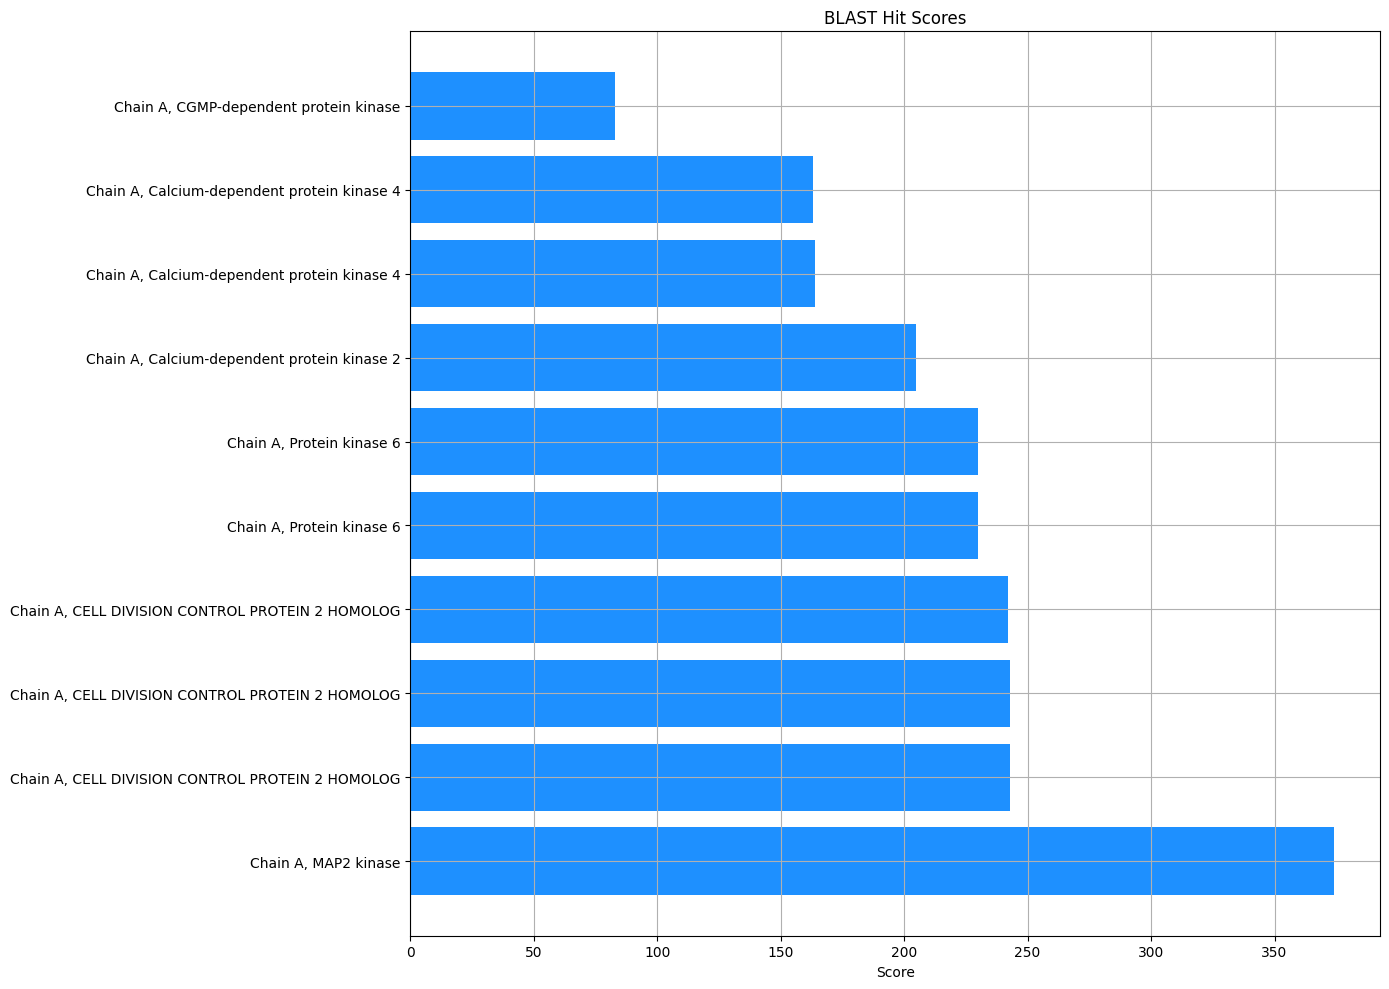

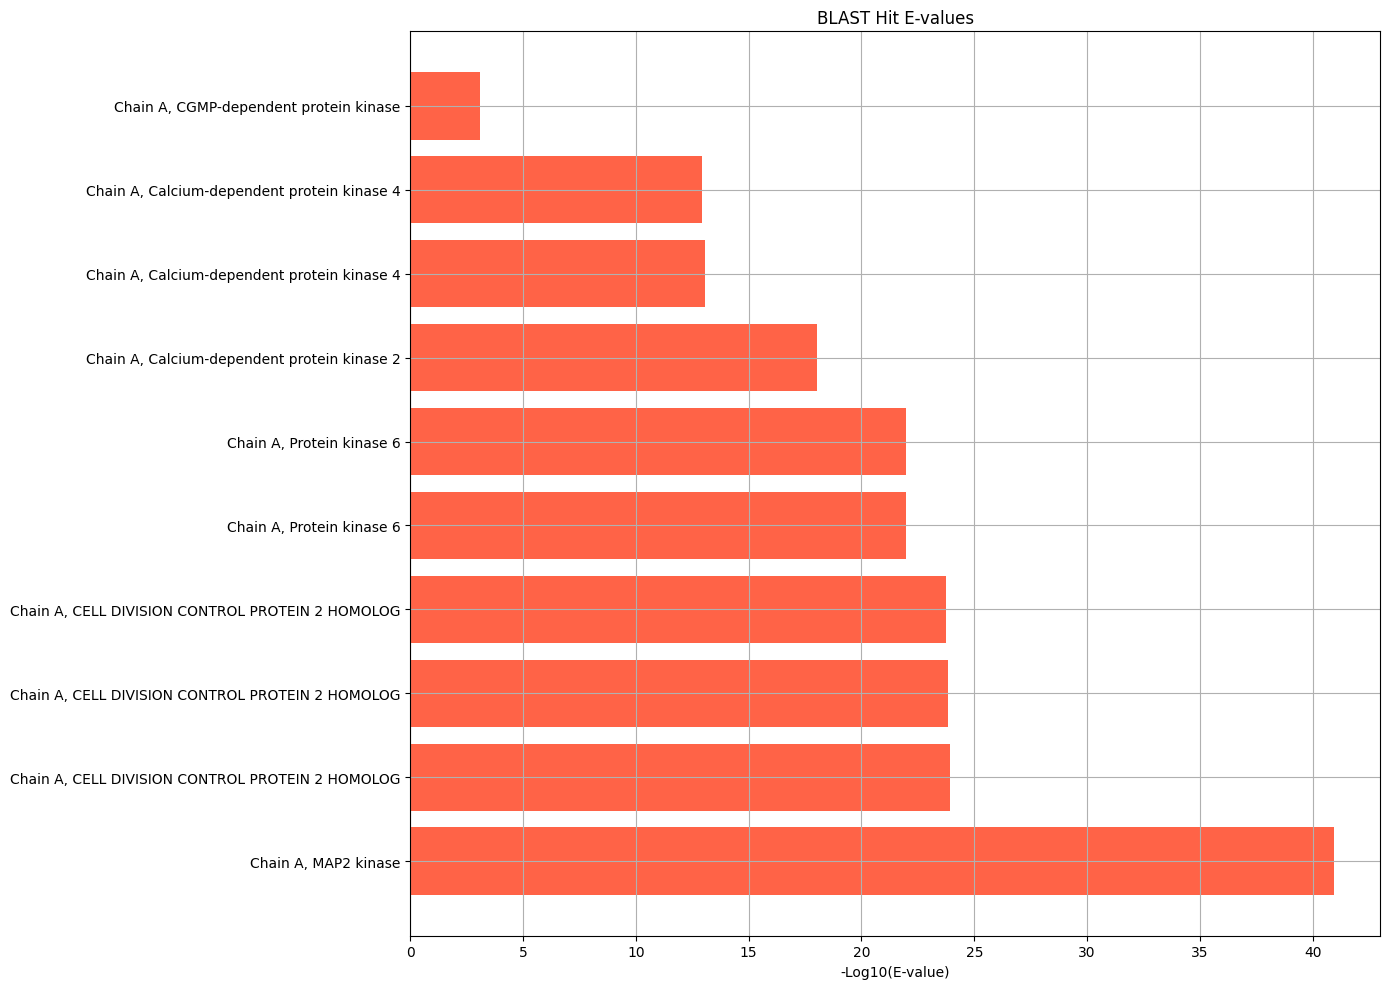

In [ ]:
# Example usage
json_file_path = '/content/drive/MyDrive/jsonfolder/5833_sorted.json'
df = load_and_prepare_data(json_file_path)
plot_scores(df)
plot_e_values(df)


## Next Steps for Refining BLAST Search Parameters

As we progress with our analysis and based on initial results, consider the following modifications to the BLAST search parameters to optimize performance and relevance of the results:

1. **E-value Threshold**:
   - **Consider lowering the `expect` value** to 0.01 or even 0.001 to focus on more statistically significant hits, reducing the noise from less significant matches.

2. **Enable Filtering**:
   - **Enable the low-complexity filter** (`filter="T"`) to help avoid non-specific matches in low-complexity regions or repetitive sequences.

3. **Substitution Matrix**:
   - **Evaluate the use of different matrices** such as PAM30 or BLOSUM80, depending on the evolutionary distances expected among the proteins being studied.

4. **Limiting Results**:
   - **Reduce `alignments` and `hitlist_size`** to 20 or even 10 to concentrate on the most relevant hits, minimizing clutter from redundant or less relevant data.

5. **Database Selection**:
   - **Consider switching to a curated database** like SwissProt for queries where quality and annotation reliability are paramount, as it has less redundancy than the nr database.

6. **Taxonomic Filtering**:
   - **Use the `entrez_query` parameter** to narrow down searches to specific taxonomic groups if the study is focused on particular organisms or taxa.

These suggestions are intended to be tested iteratively. Adjustments should be made based on the specific requirements of your research and the results obtained from preliminary searches.
